Genera un modello di ML in grado di riconoscere i tumori al seno maligni usando i dati a disposizione. 
<br>
Nello specifico, devi creare un modello di classificazione che :
1. ha un accuracy sul test set di almeno 0.96
2. ha un AUC sul test set di almeno 0.98 
3. ha un recall di 1 (0 false negative)

<br>

una volta fatto, fornisci la classificazione per i nuovi dati ed esporta in un file:
- id paziente
- classificazione modello
- prob associata alla classificazione

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report


In [38]:
random_seed = 0

# import dataset

In [39]:

BASE_URL="https://raw.githubusercontent.com/ProfAI/machine-learning-fondamenti/main/datasets/"
df = pd.read_csv(BASE_URL+"breast_cancer.csv")
df.head()

,ID number,diagnosis,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


In [40]:
df.count()

ID number                  563
diagnosis                  563
radius mean                563
texture mean               563
perimeter mean             563
area mean                  563
smoothness mean            563
compactness mean           563
concavity mean             563
concave points mean        563
symmetry mean              563
fractal dimension mean     563
radius se                  563
texture se                 563
perimeter mean.1           563
area se                    563
smoothness se              563
compactness se             563
concavity se               563
concave points se          563
symmetry se                563
fractal dimension se       563
radius worst               563
texture worst              563
perimeter worst            563
area worst                 563
smoothness worstse         563
compactness worst          563
concavity worst            563
concave points worst       563
symmetry worst             563
fractal dimension worst    563
dtype: i

In [41]:
df = df.drop(columns=['ID number'])

dataset sbilanciato verso i tumori benigni, 62.7 % vs 37.3 %

In [42]:
df['diagnosis'].value_counts()/len(df)*100

B    62.699822
M    37.300178
Name: diagnosis, dtype: float64

In [43]:
map_dict = {'M': 1, 'B': 0}
df['diagnosis'] = df['diagnosis'].map(lambda x: map_dict[x])

In [44]:
df.head()

,diagnosis,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,1,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


### Creazione del modello 

In [45]:
X = df.drop(columns=['diagnosis'], axis=1).values
y = df['diagnosis'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [46]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((394, 30), (169, 30), (394,), (169,))

In [47]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [48]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

## Valutazione del modello 

In [49]:
y_pred_train = lr.predict(X_train)
y_proba_train = lr.predict_proba(X_train)
y_pred_test = lr.predict(X_test)
y_proba_test = lr.predict_proba(X_test)

In [50]:
train_report = classification_report(y_train, y_pred_train)
print(train_report)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       248
           1       0.98      0.97      0.98       146

    accuracy                           0.98       394
   macro avg       0.98      0.98      0.98       394
weighted avg       0.98      0.98      0.98       394



Cosa fa np.where(y_proba_train[:,1] > 0.25, 1, 0)?
- y_proba_train[:,1]: estrae solo la colonna delle probabilità della classe 1.
- np.where(... > 0.25, 1, 0): per ogni probabilità, assegna 1 se è maggiore di 0.25, altrimenti 0.

Quindi:

Se la probabilità che un esempio sia della classe 1 è maggiore di 25%, lo classifichi come 1.



modifica della treshold per ottenere 0 falsi negativi

y[:,1] sta per, prendi tutte le righe di y ma solo la seconda colonna (indice 1)

In [ ]:
y_pred_train = np.where(y_proba_train[:,1]>.25,1,0) 
y_pred_test = np.where(y_proba_test[:,1]>.25, 1, 0)

In [52]:
test_report = classification_report(y_test, y_pred_test)
print(test_report)


              precision    recall  f1-score   support

           0       1.00      0.94      0.97       105
           1       0.91      1.00      0.96        64

    accuracy                           0.96       169
   macro avg       0.96      0.97      0.96       169
weighted avg       0.97      0.96      0.96       169



In [60]:
def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision_recall = False):

    cm = confusion_matrix(y_true, y_pred)

    df_cm = pd.DataFrame(cm, index = labels,
                         columns=("Predicted" + labels[0], "Predicted" + labels[1]))
    sns.heatmap(df_cm, annot=True, fmt="g")

    if show_precision_recall:
        plt.text(0, -0.1, f"Precision: {cm[1][1]/cm[1][1]+cm[0][1]}")
        plt.text(1, -0.1, f"Recall: {cm[1][1]/cm[1][1]+cm[1][0]}")



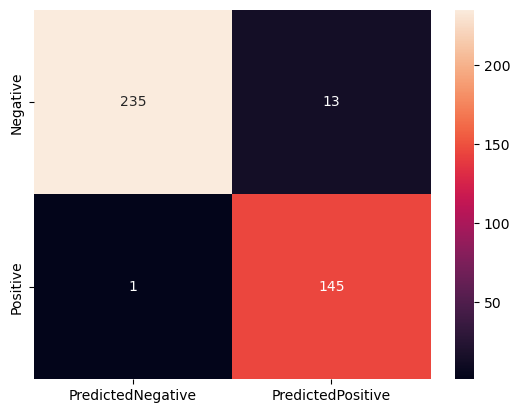

In [61]:
plot_confusion_matrix(y_train, y_pred_train)

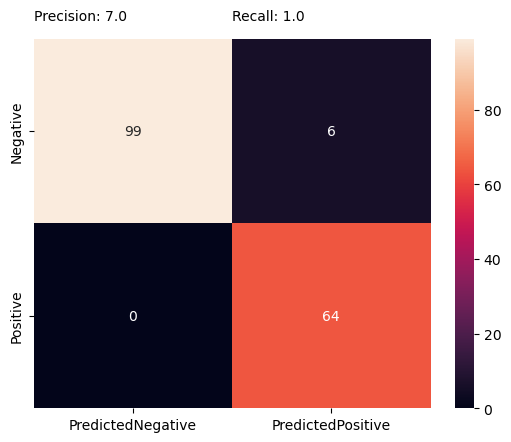

In [62]:
plot_confusion_matrix(y_test, y_pred_test, show_precision_recall=True)

In [69]:
from sklearn.metrics import RocCurveDisplay


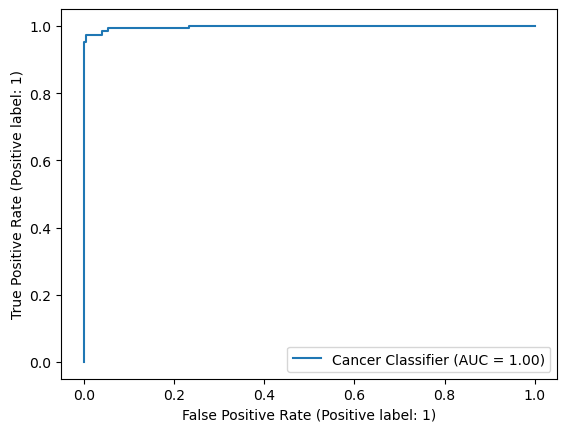

In [ ]:
RocCurveDisplay.from_estimator(lr, X_train, y_train, name="Cancer Classifier")

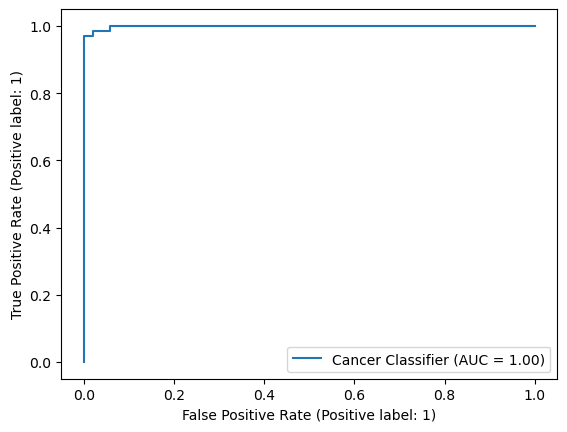

In [74]:
RocCurveDisplay.from_estimator(lr, X_test, y_test, name="Cancer Classifier")

## Classifichiamo i nuovi dati

In [77]:
df_pred = pd.read_csv(BASE_URL + "breast_cancer_pred.csv")
df_pred.head()

,ID number,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,842302,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.66560,0.71190,0.26540,0.4601,0.11890
1,8510426,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.04781,0.1885,...,15.11,19.26,99.70,711.2,0.1440,0.17730,0.23900,0.12880,0.2977,0.07259
2,8510653,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.03110,0.1967,...,14.50,20.49,96.09,630.5,0.1312,0.27760,0.18900,0.07283,0.3184,0.08183
3,8510824,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.02076,0.1815,...,10.23,15.66,65.13,314.9,0.1324,0.11480,0.08867,0.06227,0.2450,0.07773
4,859487,12.780,16.49,81.37,502.5,0.09831,0.05234,0.03653,0.02864,0.1590,...,13.46,19.76,85.67,554.9,0.1296,0.07061,0.10390,0.05882,0.2383,0.06410


In [78]:
X = df_pred.drop(["ID number"], axis=1).values
X = ss.transform(X)

In [79]:
y_proba_new_data = lr.predict_proba(X)
y_pred_new_data = np.where(y_proba_new_data[:,1]>.25,1,0)

In [80]:
y_pred_new_data

array([1, 0, 0, 0, 0])

y_proba_new_data contiene due probabilità, una legata alla classe positiva e una legata alla classe negativa, devo prendere la massima (.max) per tutte le righe (axis = 1)

In [84]:
df_result = pd.DataFrame({
    "ID": df_pred["ID number"],
    "prediction": y_pred_new_data,
    "prediction_proba": y_proba_new_data.max(axis=1).round(4)
})

In [ ]:
df_result

,ID,prediction,prediction_proba
0,842302,1,1.0000
1,8510426,0,0.8776
2,8510653,0,0.9951
3,8510824,0,0.9999
4,859487,0,0.9982
